In [1]:
import os
import tempfile
from urllib.parse import urlparse

In [4]:
import matplotlib.pyplot as plt
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets.utils import download_url

In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

In [6]:
import rasterio

In [10]:
from dotenv import load_dotenv
import os

# Load environment variables from a .env file located in the same directory as this script
load_dotenv()

# Now you can access the environment variable
cloud_project = os.environ.get("GOOGLE_CLOUD_PROJECT_NAME")
key_path = os.environ.get("GOOGLE_CLOUD_KEY_PATH")

print(cloud_project)
print(key_path)

hotspotstoplight
C:\Users\Nissim\Documents\google-keys\hotspotstoplight-67f59ac93e89.json


In [11]:
from google.cloud import storage

# Initialize a Google Cloud Storage client
client = storage.Client()

# Your bucket name
bucket_name = "hotspotstoplight_floodmapping"

# Create a GCS Bucket object
bucket = client.get_bucket(bucket_name)

In [13]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

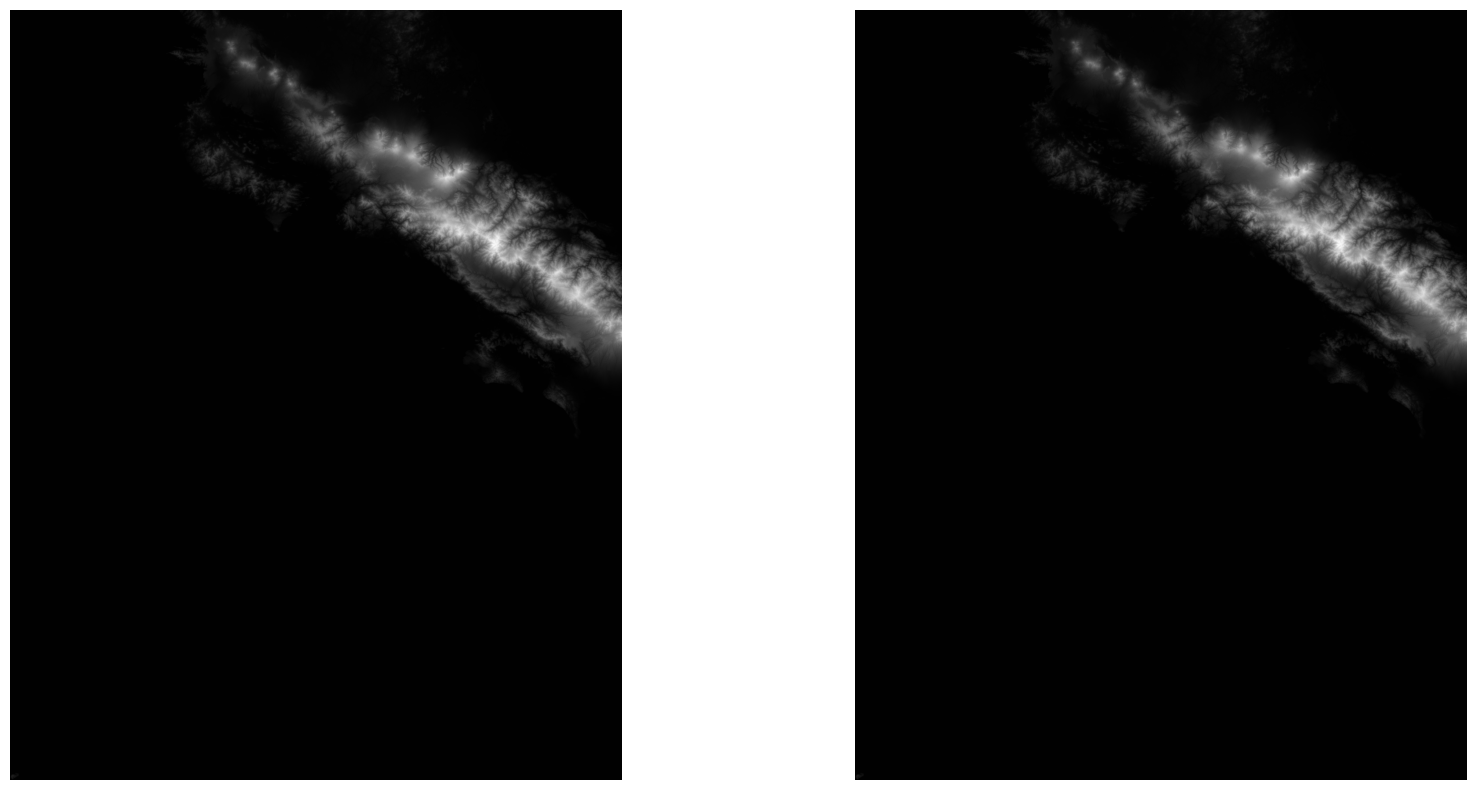

In [14]:
import matplotlib.pyplot as plt
import rasterio

# List of your GCS image paths
gcs_paths = [
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2018-10-02.tif",
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2021-07-22.tif",
]

# Initialize a list to hold the image data
images = []

# Read each image
for path in gcs_paths:
    with rasterio.open(path, 'r') as src:
        # Read the image as numpy array and append to the list
        # Here, we're reading the first band as an example
        images.append(src.read(1))

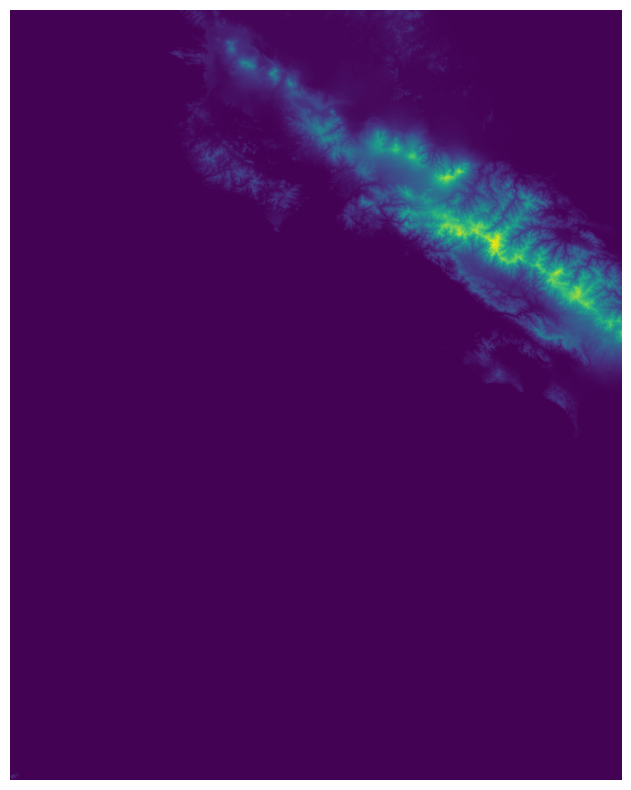

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0], cmap='viridis')  # Using 'viridis' colormap for the first image
plt.axis('off')  # Remove axes for clarity
plt.show()

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import rasterio

class CustomGeospatialDataset(Dataset):
    def __init__(self, urls, transform=None):
        self.urls = urls
        self.transform = transform

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        with rasterio.open(self.urls[idx]) as src:
            img = src.read() # Reads all bands
            img = np.moveaxis(img, 0, -1)  # Move channels to the end (H, W, C)

            # Assuming last channel is label and rest are features
            features = img[..., :-1]
            label = img[..., -1]

        if self.transform:
            features = self.transform(features)

        return features, label


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 512) # Adjust size based on your input image size
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64) # Adjust flattening based on your input image size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [30]:
from torch.optim import Adam

# Example URLs - replace with your actual URLs
urls = [
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2018-10-02.tif",
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2021-07-22.tif",
]

# Assuming binary classification for simplicity
num_classes = 2
model = SimpleCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Loading the dataset
dataset = CustomGeospatialDataset(urls=urls)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Training loop
for epoch in range(10):  # Example: 10 epochs
    for features, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(features.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[2, 7077, 5620, 15] to have 3 channels, but got 7077 channels instead